In [1]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from itertools import combinations
from sklearn.metrics import f1_score

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_20_with_tiers.csv')
df = df[df['round'] == 'Second Round']
print(df.shape)
df.head()

(320, 73)


,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,win,kenpom_adjem,kenpom_adjoe,...,D_B,D_C,D_D,D_F,F_S,F_A,F_B,F_C,F_D,F_F
1,2004,East,Second Round,1,2004 Saint Joseph's,8,2004 Texas Tech,1,11.7131,82.5819,...,0,0,0,0,0,0,0,0,0,0
3,2004,East,Second Round,12,2004 Manhattan,4,2004 Wake Forest,0,-10.7518,76.1598,...,0,0,0,0,0,0,0,0,0,0
6,2004,East,Second Round,7,2004 Memphis,2,2004 Oklahoma St.,0,-8.7899,74.5241,...,0,0,0,0,0,0,0,0,0,0
11,2004,East,Second Round,6,2004 Wisconsin,3,2004 Pittsburgh,0,-1.4764,73.7798,...,0,0,0,0,0,0,0,0,0,0
17,2004,Midwest,Second Round,6,2004 Boston College,3,2004 Georgia Tech,0,-10.2469,69.4213,...,0,0,0,0,0,0,0,0,0,0


In [2]:
df['win'].value_counts(normalize=True)

1   0.5062
0   0.4938
Name: win, dtype: float64

In [3]:
df.columns.to_list()

['year',
 'region',
 'round',
 'high_bracket_seed',
 'high_bracket_team',
 'low_bracket_seed',
 'low_bracket_team',
 'win',
 'kenpom_adjem',
 'kenpom_adjoe',
 'kenpom_adjde',
 'off_eff',
 'def_eff',
 'tempo',
 'adj_tempo',
 'off_efg_pct',
 'off_to_pct',
 'off_or_pct',
 'off_ft_rate',
 'def_efg_pct',
 'def_to_pct',
 'def_or_pct',
 'def_ft_rate',
 'off_2pt_pct',
 'off_3pt_pct',
 'off_ft_pct',
 'off_block_pct',
 'def_2pt_pct',
 'def_3pt_pct',
 'def_ft_pct',
 'def_block_pct',
 'off_ast_rate',
 'off_stl_rate',
 'def_ast_rate',
 'def_stl_rate',
 'high_tier',
 'low_tier',
 'S_S',
 'S_A',
 'S_B',
 'S_C',
 'S_D',
 'S_F',
 'A_S',
 'A_A',
 'A_B',
 'A_C',
 'A_D',
 'A_F',
 'B_S',
 'B_A',
 'B_B',
 'B_C',
 'B_D',
 'B_F',
 'C_S',
 'C_A',
 'C_B',
 'C_C',
 'C_D',
 'C_F',
 'D_S',
 'D_A',
 'D_B',
 'D_C',
 'D_D',
 'D_F',
 'F_S',
 'F_A',
 'F_B',
 'F_C',
 'F_D',
 'F_F']

In [4]:
eda_df = df[[
 'win',
 'kenpom_adjem',
 'kenpom_adjoe',
 'kenpom_adjde',
 'off_eff',
 'def_eff',
 'off_efg_pct',
 'off_or_pct',
 'off_ft_rate',
 'def_efg_pct',
 'def_to_pct',
 'def_or_pct',
 'def_ft_rate',
 'off_2pt_pct',
 'off_3pt_pct',
 'def_2pt_pct',
 'def_block_pct',
 'S_B',
 'S_C',
 'A_C',
 'A_D',
 'B_S',
 'B_D',
 'C_S',
 'C_A',
 'C_B',
 'C_D']]  

In [5]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((224, 26), (96, 26))

### I. Lasso Regression

In [6]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [7]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(scaler.transform(X_train), y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [8]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 26
selected features: 20
features with coefficients shrank to zero: 6


In [9]:
selected_feat

Index(['kenpom_adjem', 'kenpom_adjoe', 'off_eff', 'def_eff', 'off_or_pct',
       'off_ft_rate', 'def_to_pct', 'def_or_pct', 'def_ft_rate', 'off_2pt_pct',
       'off_3pt_pct', 'def_block_pct', 'S_C', 'A_C', 'A_D', 'B_S', 'B_D',
       'C_A', 'C_B', 'C_D'],
      dtype='object')

## II. Backward Selection

In [10]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [11]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [12]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['kenpom_adjem', 'def_eff', 'def_ft_rate', 'off_3pt_pct', 'S_B',
       'S_C', 'A_D', 'C_S', 'C_A', 'C_D'], dtype=object)

In [13]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8859130156699713
Test set
Random Forests roc-auc: 0.7839285714285714


In [14]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9198113207547169
Test set
Random Forests roc-auc: 0.7839285714285714


### III. Forward Selection

In [15]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [16]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['kenpom_adjem', 'def_eff', 'def_ft_rate', 'off_3pt_pct', 'S_B',
       'S_C', 'A_D', 'C_S', 'C_A', 'C_D'], dtype=object)

In [17]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.8859130156699713
Test set
Random Forests roc-auc: 0.7839285714285714


### IV. ROC-AUC

In [18]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.5553571428571429,
 0.6267857142857143,
 0.6053571428571428,
 0.4839285714285714,
 0.4839285714285714,
 0.4714285714285715,
 0.5464285714285714,
 0.5107142857142857,
 0.5142857142857142,
 0.47678571428571426,
 0.5410714285714286,
 0.4839285714285714,
 0.6339285714285715,
 0.5232142857142856,
 0.5660714285714286,
 0.5821428571428572,
 0.5589285714285713,
 0.6428571428571428,
 0.505357142857143,
 0.5089285714285714,
 0.5160714285714285,
 0.5089285714285714,
 0.5125,
 0.5607142857142857,
 0.4607142857142857,
 0.5089285714285714]

Text(0, 0.5, 'roc-auc')

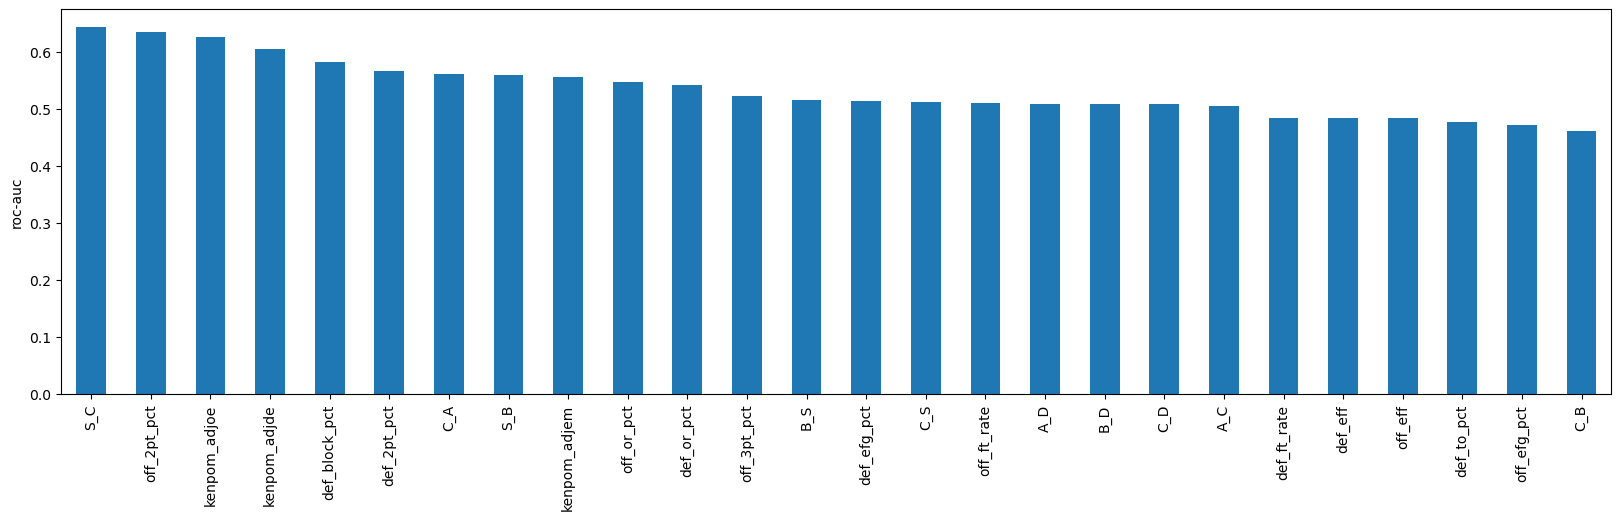

In [19]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [20]:
len(roc_values[roc_values > 0.5])

20

In [21]:
len(roc_values[roc_values > 0.6])

4

In [22]:
roc_values[roc_values > 0.5]

kenpom_adjem    0.5554
kenpom_adjoe    0.6268
kenpom_adjde    0.6054
off_or_pct      0.5464
off_ft_rate     0.5107
def_efg_pct     0.5143
def_or_pct      0.5411
off_2pt_pct     0.6339
off_3pt_pct     0.5232
def_2pt_pct     0.5661
def_block_pct   0.5821
S_B             0.5589
S_C             0.6429
A_C             0.5054
A_D             0.5089
B_S             0.5161
B_D             0.5089
C_S             0.5125
C_A             0.5607
C_D             0.5089
dtype: float64

### V. Exhaustive Feature Selection

In [23]:
from sklearn.linear_model import LogisticRegression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_scaled2 = X_train_scaled[[
    'kenpom_adjem', 
    'kenpom_adjoe', 
    'off_eff', 
    'def_eff', 
    'off_or_pct',
    'off_ft_rate', 
    'def_to_pct', 
    'def_or_pct', 
    'def_ft_rate', 
    'off_2pt_pct',
    'off_3pt_pct', 
    'def_block_pct', 
    'S_C', 
    'A_C', 
    'A_D', 
    'B_S', 
    'B_D',
    'C_A', 
    'C_B', 
    'C_D'   
]]

X_test_scaled2 = X_test_scaled[[
    'kenpom_adjem', 
    'kenpom_adjoe', 
    'off_eff', 
    'def_eff', 
    'off_or_pct',
    'off_ft_rate', 
    'def_to_pct', 
    'def_or_pct', 
    'def_ft_rate', 
    'off_2pt_pct',
    'off_3pt_pct', 
    'def_block_pct', 
    'S_C', 
    'A_C', 
    'A_D', 
    'B_S', 
    'B_D',
    'C_A', 
    'C_B', 
    'C_D'
]]

### VI. XGBoost

In [24]:
import xgboost
print(xgboost.__version__)

2.1.3


In [28]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4],
    'learning_rate': [0.001, 0.005, 0.01],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.4, 0.5, 0.6, 0.7],
    'colsample_bytree': [0.4, 0.5, 0.6, 0.7],
    'gamma': [0, 0.1, 0.2]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2160 candidates, totalling 10800 fits
Best Hyperparameters: {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.5}


In [29]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    **best_params
)

best_xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [30]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")


Log Loss on test set: 0.5679643774869699


In [31]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train)
y_test_pred = best_xgb_model.predict(X_test)

# Calculate F1 scores
f1_train = f1_score(y_train, y_train_pred)
f1_test = f1_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {f1_train:.2f}")
print(f"F1 Score on Test Data: {f1_test:.2f}")

F1 Score on Training Data: 0.74
F1 Score on Test Data: 0.71
